In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
module = fc.eightb.preselection.ranked_quadh
signal = ObjIter([Tree(fn, use_gen=False) for fn in module.signal_list[::3]])
bkg = ObjIter([Tree(module.QCD_B_List, use_gen=False), Tree(module.TTJets, use_gen=False)])

100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


In [4]:
(signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'jet', ptordered=True))

[None, None, None, None, None]

In [5]:
def relative_btag(t):
  btagavg = ak.mean(t.jet_btag,axis=-1)
  btagstd = ak.std( t.jet_btag,axis=-1)
  relbtag = (t.jet_btag-btagavg)/btagstd
  btagmulti = { f'n_{wplabels[wp+1]}_btag':ak.sum(t.jet_btag>jet_btagWP[wp+1],axis=-1) for wp in range(3)}
  t.extend(
    btagavg=btagavg,
    btagstd=btagstd,
    jet_relbtag=relbtag,
    **btagmulti
  )
(signal+bkg).apply(relative_btag)

[None, None, None, None, None]

In [6]:
varinfo.jet_btag=dict(bins=(0,1,30))
varinfo.jet_relbtag=dict(bins=(-2,2,30))

100%|██████████| 1/1 [00:06<00:00,  6.22s/it]


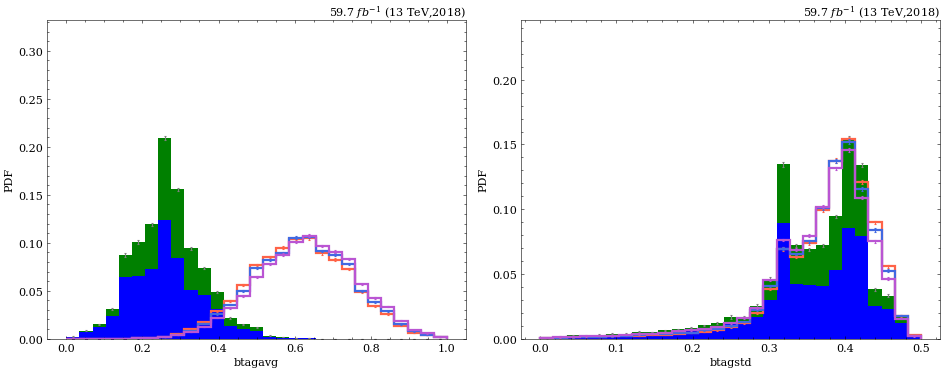

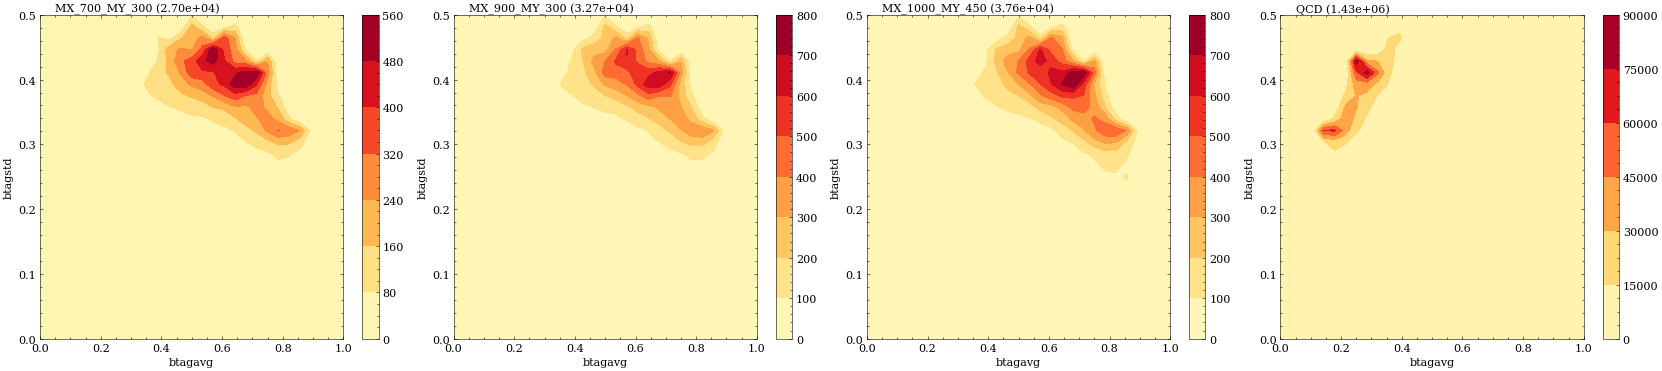

In [7]:
varinfo.btagavg=dict(bins=(0,1,30))
varinfo.btagstd=dict(bins=(0,0.5,30))

study.quick(
  signal+bkg, stacked=True,
  efficiency=True,
  varlist=['btagavg','btagstd'],
)

fig, axs = study.quick2d(
  signal, 
  varlist=['btagavg','btagstd'],
  return_figax=True,
  contour=True,
  dim=(-1,4),
)

study.quick2d_region(
  bkg,
  varlist=['btagavg','btagstd'],
  figax=(fig,axs.flat[-1]),
  contour=True,
)

100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


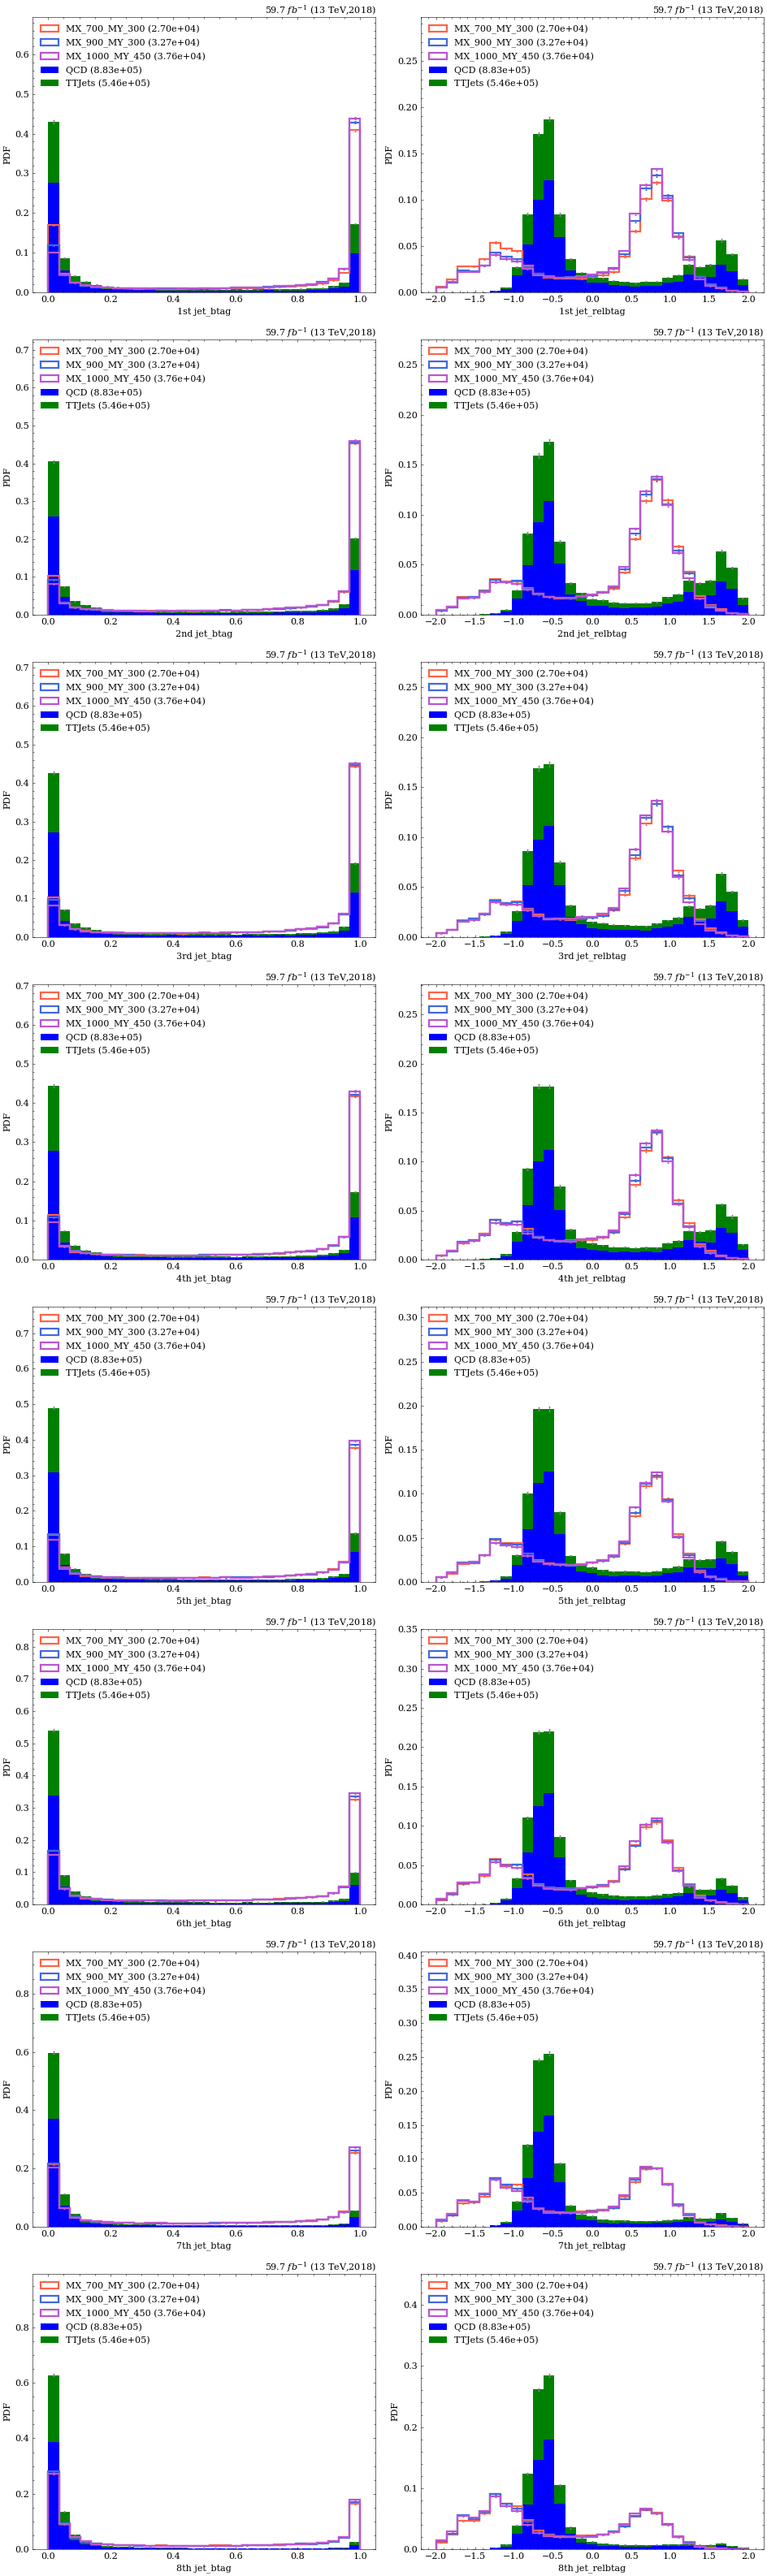

In [8]:
fig, axs = study.get_figax(2*8, dim=(8,2))
for i in range(8):
  study.quick(
    signal+bkg, legend=True, stacked=True,
    varlist=[f'jet_btag[:,{i}]', f'jet_relbtag[:,{i}]'],
    # xlabels=[f'{ordinal(i+1)} jet_btag', f'{ordinal(i+1)} jet_relbtag'],
    efficiency=True,

    figax=(fig,axs.flat[2*i:2*i+2])
  )

100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


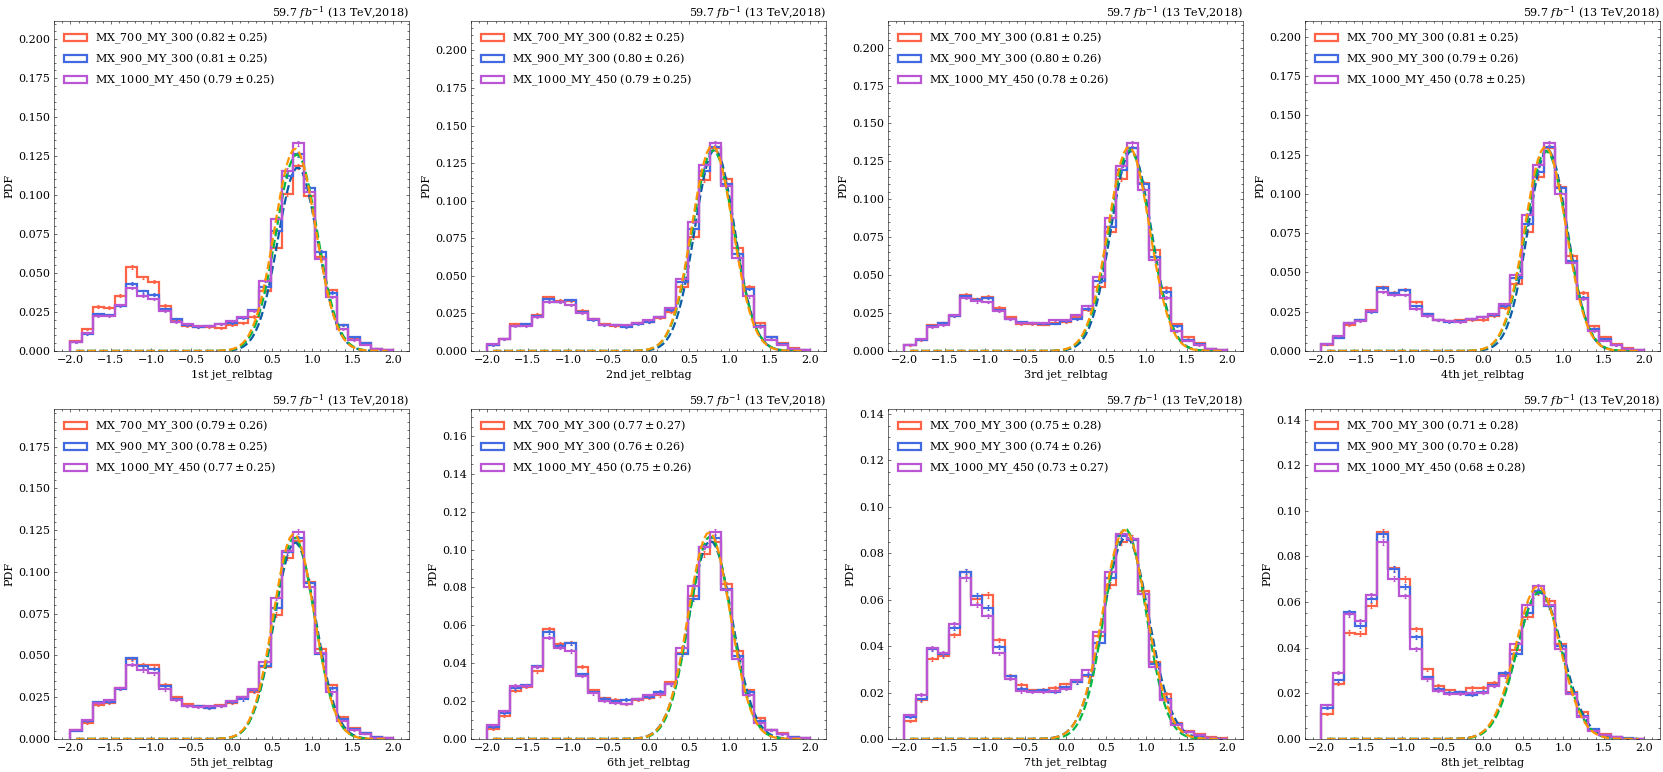

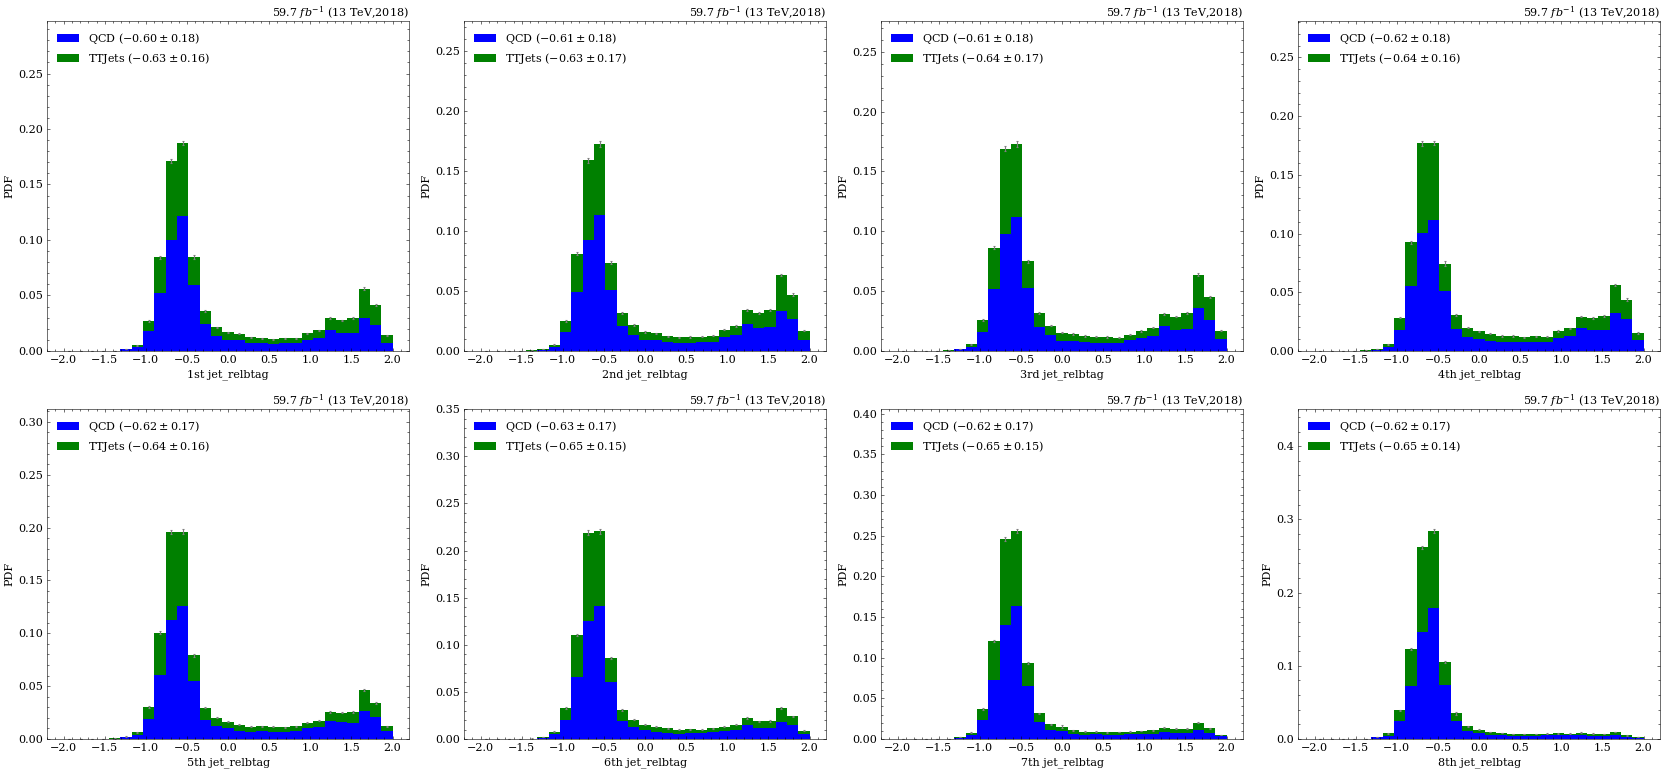

In [9]:
study.quick(
  signal, legend=True, h_label_stat="${fit.mu:0.2f}\pm{fit.sigma:0.2f}$",
  varlist=[f'jet_relbtag[:,{i}]' for i in range(8)],
  h_fit='gaussian', h_fit_peak=True, h_fit_bounds=(0,1.5), h_fit_show=True,
  efficiency=True,
)
study.quick(
  bkg, stacked=True, legend=True, h_label_stat="${fit.mu:0.2f}\pm{fit.sigma:0.2f}$",
  varlist=[f'jet_relbtag[:,{i}]' for i in range(8)],
  h_fit='gaussian', h_fit_peak=True, h_fit_bounds=(-1,0), h_fit_show=True,
  efficiency=True,
)

100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


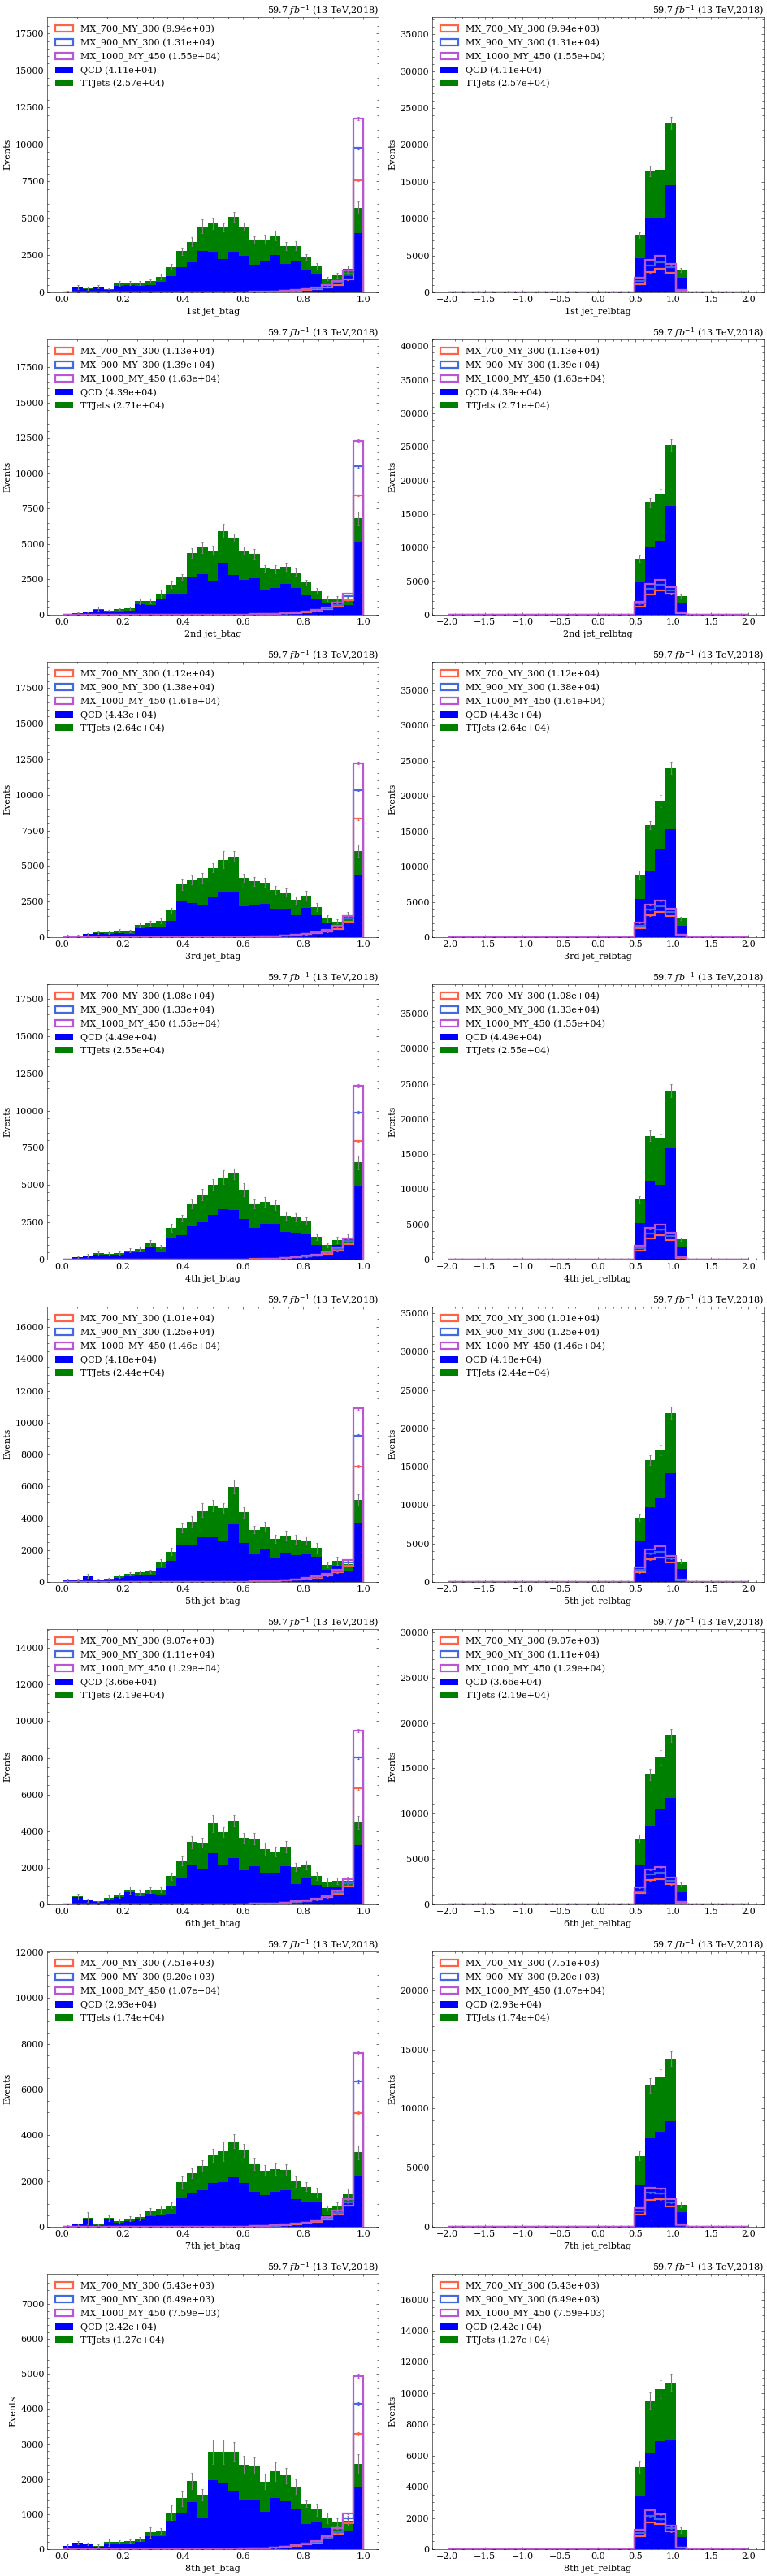

In [10]:
fig, axs = study.get_figax(2*8, dim=(8,2))
for i in range(8):
  study.quick(
    signal+bkg, legend=True, stacked=True,
    masks=lambda t : np.abs(t.jet_relbtag[:,i]-0.8)<0.25,
    varlist=[f'jet_btag[:,{i}]', f'jet_relbtag[:,{i}]'],
    # efficiency=True,

    figax=(fig,axs.flat[2*i:2*i+2])
  )

100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


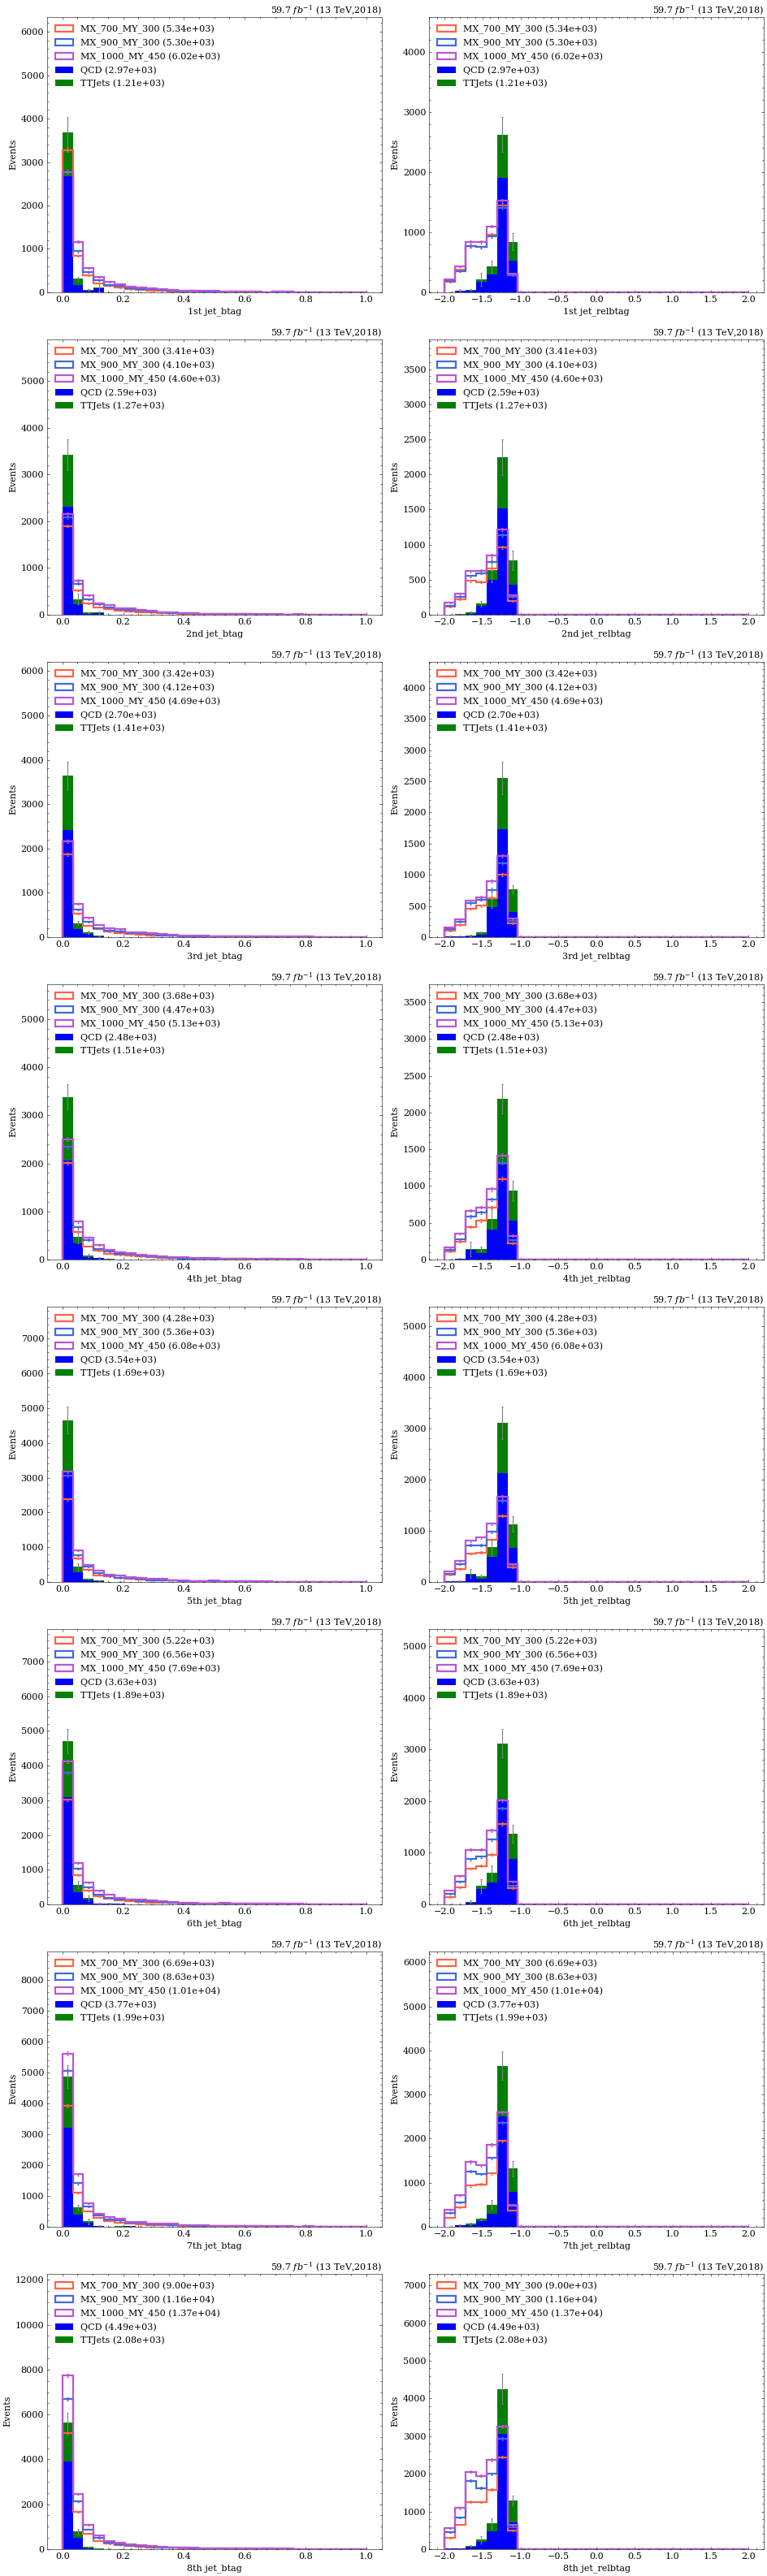

In [11]:
fig, axs = study.get_figax(2*8, dim=(8,2))
for i in range(8):
  study.quick(
    signal+bkg, legend=True, stacked=True,
    masks=lambda t : (t.jet_relbtag[:,i]+0.6) < -3*0.18,
    varlist=[f'jet_btag[:,{i}]', f'jet_relbtag[:,{i}]'],
    # efficiency=True,

    figax=(fig,axs.flat[2*i:2*i+2])
  )

100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


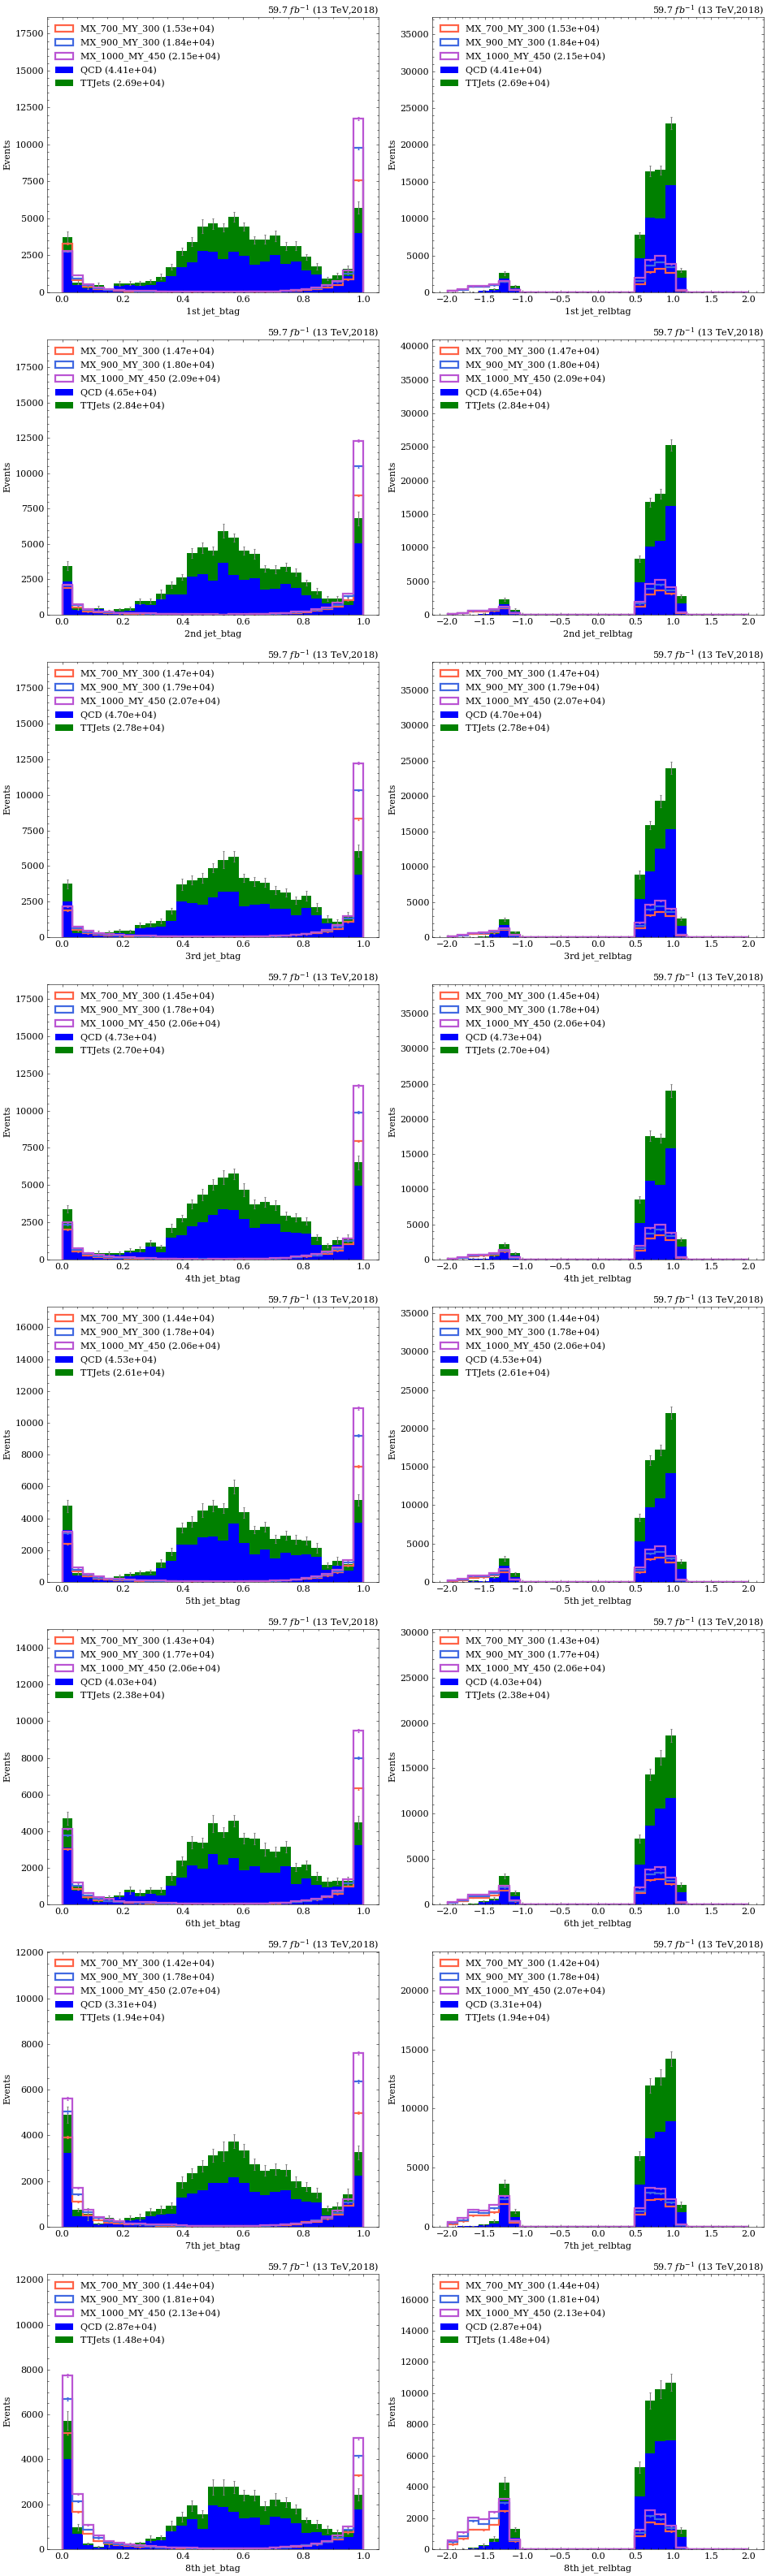

In [12]:
fig, axs = study.get_figax(2*8, dim=(8,2))
for i in range(8):
  study.quick(
    signal+bkg, legend=True, stacked=True,
    masks=lambda t : ((t.jet_relbtag[:,i]+0.6) < -3*0.18) | (np.abs(t.jet_relbtag[:,i]-0.8)<0.25),
    varlist=[f'jet_btag[:,{i}]', f'jet_relbtag[:,{i}]'],
    # efficiency=True,

    figax=(fig,axs.flat[2*i:2*i+2])
  )

100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


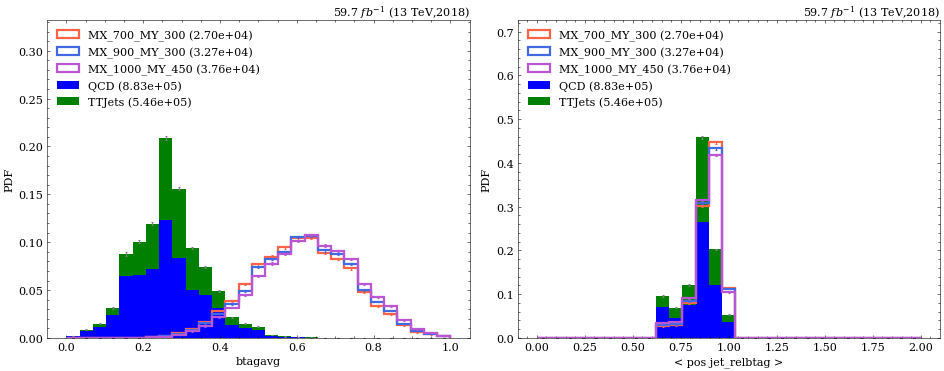

In [13]:
varinfo.btagavg=dict(bins=(0,1,30))

class pos_relbtag_avg(ObjTransform):
  def init(self):
    self.xlabel = '< pos jet_relbtag >'
    self.bins   = (0,2,30)
  def __call__(self, t):
    return ak.mean(np.abs(t.jet_relbtag), axis=-1)

study.quick(
  signal+bkg, stacked=True, legend=True,
  varlist=['btagavg', pos_relbtag_avg()],
  efficiency=True,
)

100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


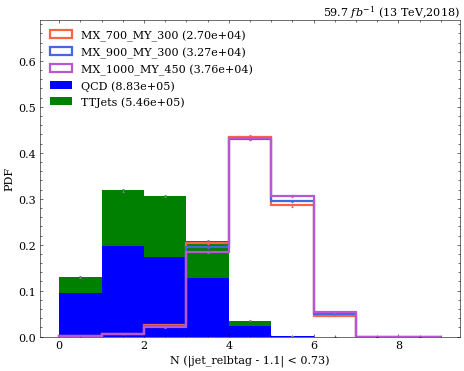

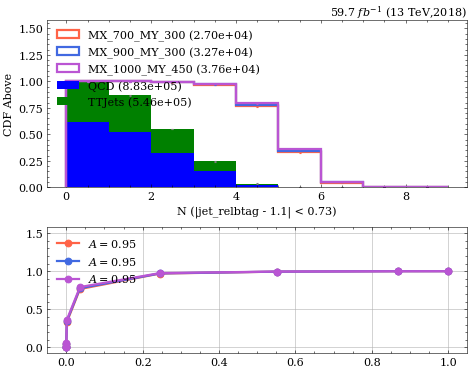

In [14]:
class n_relbtag(ObjTransform):
  def init(self):
    transforms = {
      np.abs:"|%s|"
    }

    def centers(center):
      if center == 0: return ""
      if center < 0 : return f" + {-center:0.2}"
      if center > 0 : return f" - { center:0.2}"

    self.xlabel =[
      (transforms.get(transform, "%s") % (f"jet_relbtag{centers(center)}")) + f" < {bounds:0.2}"
      for transform, center, bounds in self.cuts
    ]
    self.xlabel = "N (" + " | ".join(self.xlabel) + ")"
    self.bins = np.arange(10)
  def __call__(self, t):
    mask = None
    for transform, center, bounds in self.cuts:
      if transform is None: transform = lambda v : v
      _mask = transform(t.jet_relbtag - center) < bounds
      if mask is None: mask = _mask 
      else: mask = mask | _mask

    return ak.sum(mask,axis=-1)

relbtag_multi = n_relbtag(cuts=[(np.abs, 1.1, 0.73)])

study.quick(
  signal+bkg, stacked=True, legend=True,
  varlist=[relbtag_multi],
  efficiency=True,
)

study.quick(
  signal+bkg, stacked=True, legend=True,
  varlist=[relbtag_multi],
  cumulative=-1, correlation=True,
)

100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


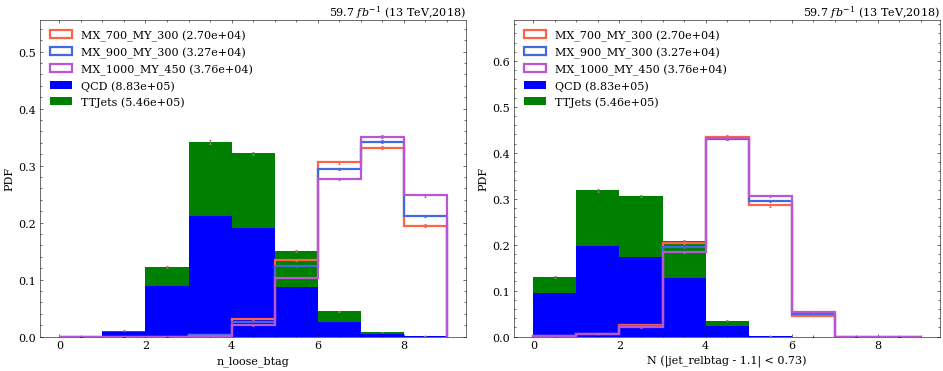

In [15]:
study.quick(
  signal+bkg, stacked=True, legend=True,
  varlist=['n_loose_btag', relbtag_multi],
  efficiency=True,
)

100%|██████████| 1/1 [00:04<00:00,  4.68s/it]


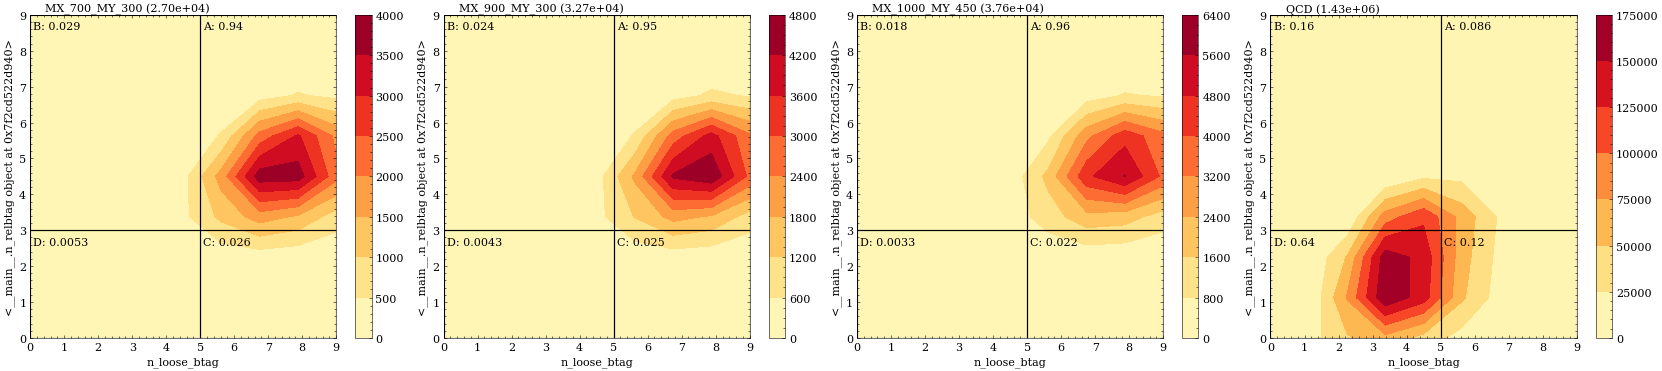

In [16]:
fig, axs = study.get_figax(4, dim=(-1,4))

get_abcd = draw_abcd(x_r=(0,5,9), y_r=(0,3,9))

study.quick2d(
  signal,
  varlist=['n_loose_btag', relbtag_multi],
  contour=True,
  exe=get_abcd,
  figax=(fig, axs.flat[:3])
)

study.quick2d_region(
  bkg,
  varlist=['n_loose_btag',relbtag_multi],
  contour=True,
  exe=get_abcd,
  figax=(fig, axs.flat[3]),
)


In [17]:
def get_region_score(x, y):
  bdt = ABCD(
  features=['X_pt'],
  a = lambda t : (t.n_loose_btag >  x) & (t.relbtag_multi >  y),
  b = lambda t : (t.n_loose_btag <= x) & (t.relbtag_multi >  y),
  c = lambda t : (t.n_loose_btag >  x) & (t.relbtag_multi <= y),
  d = lambda t : (t.n_loose_btag <= x) & (t.relbtag_multi <= y),
  )

  bdt.train(bkg, reweight=False)
  return np.abs(bdt.results(bkg)['k_factor_score'])

In [18]:
X = np.arange(1,7)
Y = np.arange(1,5)
X, Y = np.meshgrid(X, Y)

In [19]:
def best_region(center=0.8, width=0.7):
  relbtag_multi = n_relbtag(cuts=[(np.abs, center, width)])
  bkg.apply(lambda t : t.extend(relbtag_multi=relbtag_multi(t)))
  Z = np.vectorize(get_region_score)(X,Y)
  z = np.min(Z)
  x = X[Z==z][0]
  y = Y[Z==z][0]
  return (x, y, z)

In [20]:
get_region_score(4,2)

ValueError: key "relbtag_multi" does not exist (not in record)

(https://github.com/scikit-hep/awkward-1.0/blob/1.8.0/src/libawkward/util.cpp#L525)

In [ ]:
features = [ f'{obj}_{var}' for obj in ['X']+eightb.ylist for var in ('m','pt') ]
bdt = ABCD(
  features=['X_pt'],
  a = lambda t : (t.n_loose_btag >  4) & (relbtag_multi(t) >  1),
  b = lambda t : (t.n_loose_btag <= 4) & (relbtag_multi(t) >  1),
  c = lambda t : (t.n_loose_btag >  4) & (relbtag_multi(t) <= 1),
  d = lambda t : (t.n_loose_btag <= 4) & (relbtag_multi(t) <= 1),
)

bdt.train(bkg, reweight=False)
bdt.print_results(bkg)

--- ABCD Results ---
k = 1.520e-01
k*(b/a)-1  = -6.875e-01
BDT(b)/a-1 = nan



100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


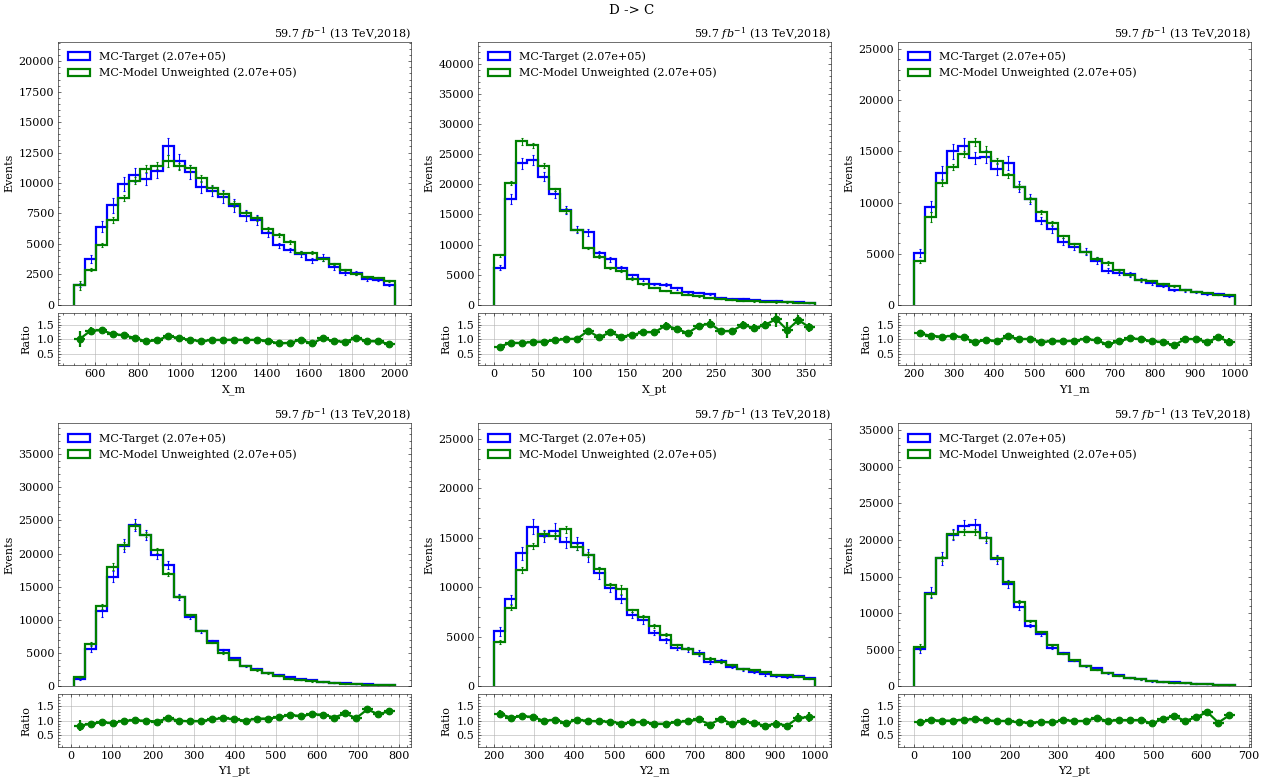

In [ ]:
study.quick_region(
  bkg, bkg, label=['MC-Target','MC-Model Unweighted'],
  legend=True,
  masks=[bdt.c]*len(bkg) + [bdt.d]*len(bkg),
  scale=[1]*len(bkg) + [bdt.scale_tree]*len(bkg),
  varlist=features,
  ratio=True,
  title='D -> C'
)

100%|██████████| 6/6 [00:17<00:00,  2.87s/it]


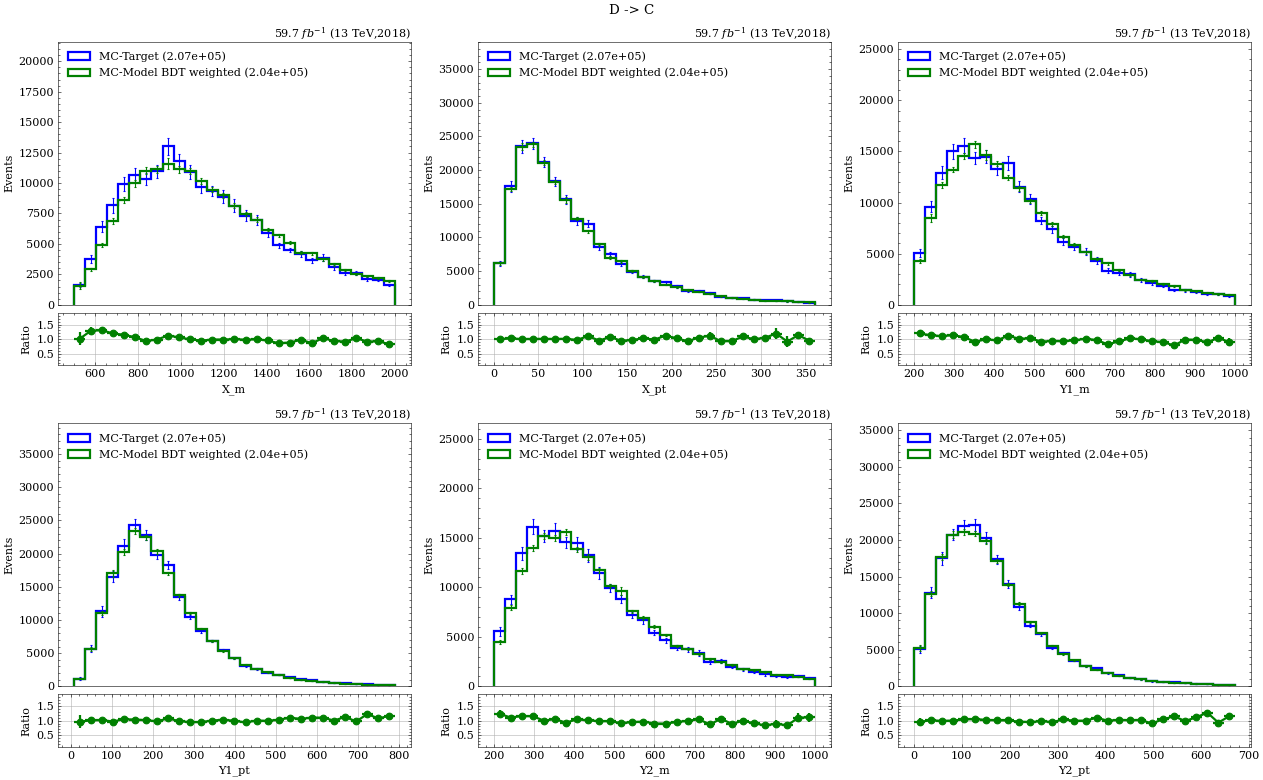

In [ ]:
study.quick_region(
  bkg, bkg, label=['MC-Target','MC-Model BDT weighted'],
  legend=True,
  masks=[bdt.c]*len(bkg) + [bdt.d]*len(bkg),
  scale=[1]*len(bkg) + [bdt.reweight_tree]*len(bkg),
  varlist=features,
  ratio=True,
  title='D -> C'
)

100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


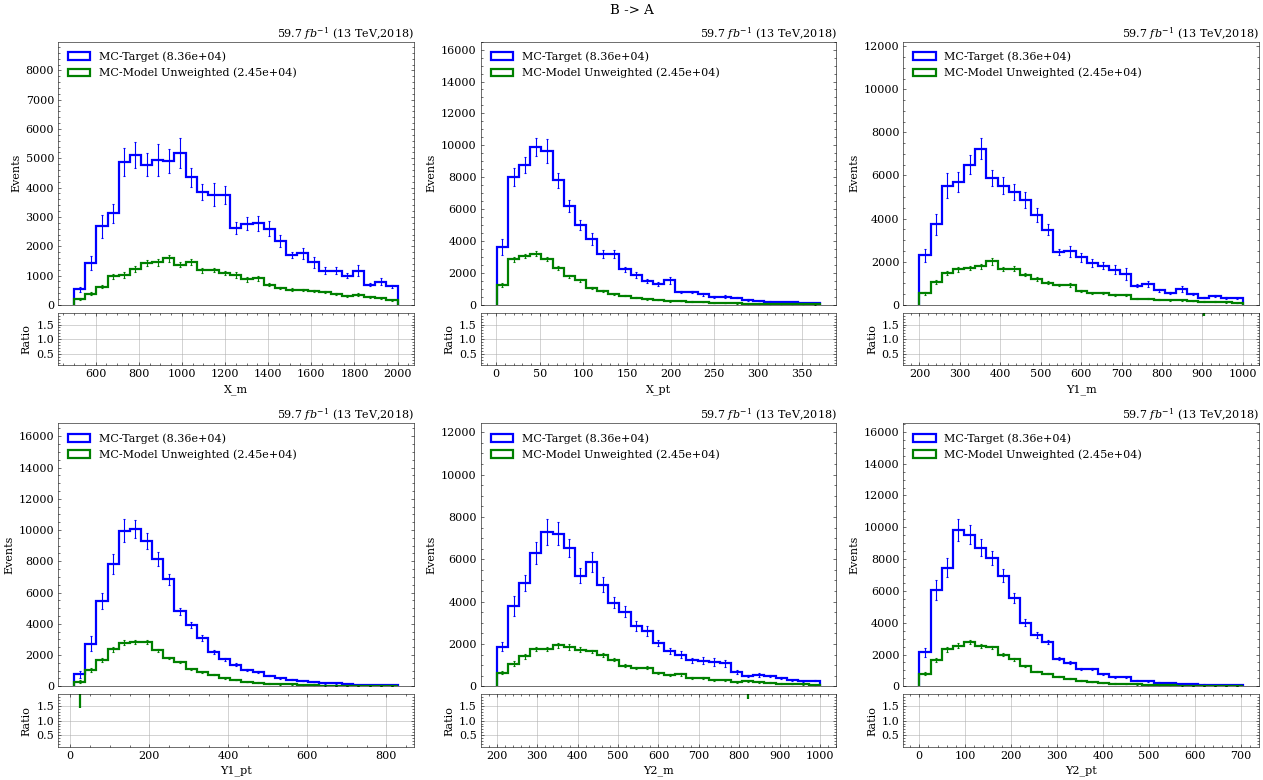

In [ ]:
study.quick_region(
  bkg, bkg, label=['MC-Target','MC-Model Unweighted'],
  legend=True,
  masks=[bdt.a]*len(bkg) + [bdt.b]*len(bkg),
  scale=[1]*len(bkg) + [bdt.scale_tree]*len(bkg),
  varlist=features,
  ratio=True,
  title='B -> A'
)

100%|██████████| 6/6 [00:17<00:00,  2.89s/it]


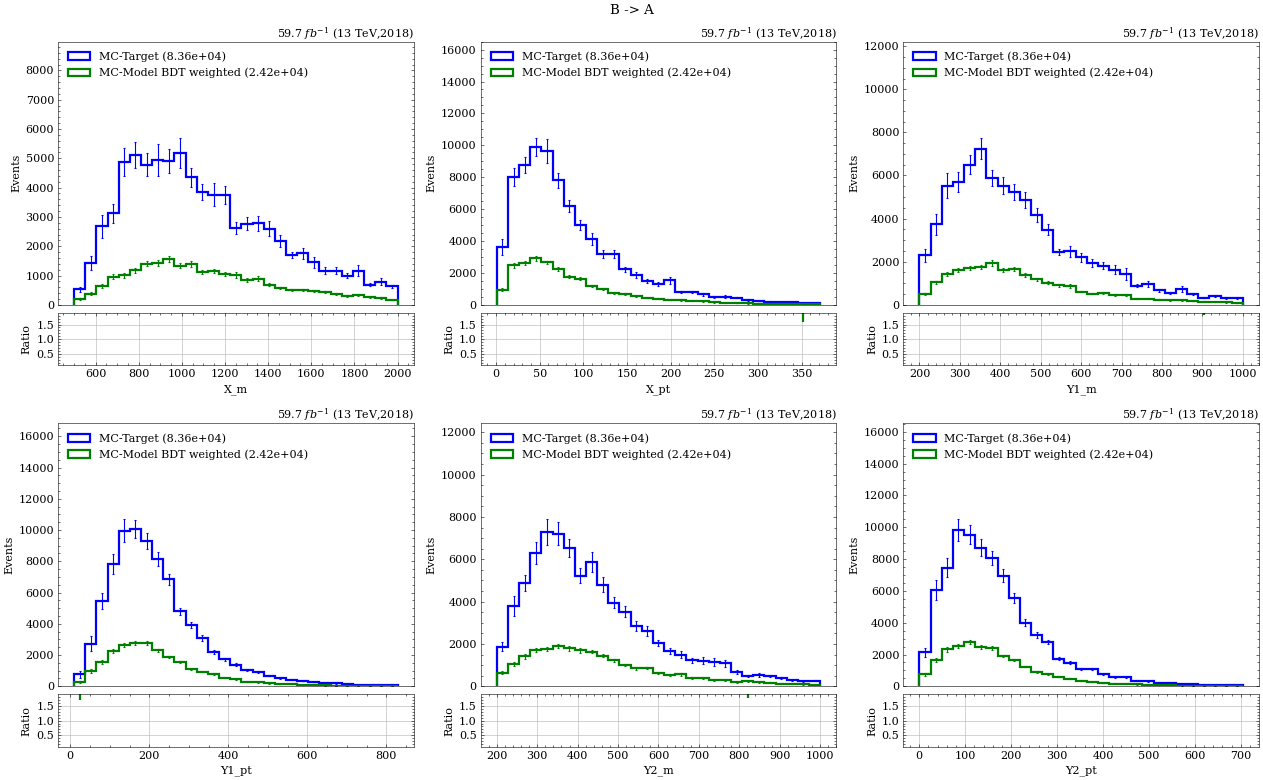

In [ ]:
study.quick_region(
  bkg, bkg, label=['MC-Target','MC-Model BDT weighted'],
  legend=True,
  masks=[bdt.a]*len(bkg) + [bdt.b]*len(bkg),
  scale=[1]*len(bkg) + [bdt.reweight_tree]*len(bkg),
  varlist=features,
  ratio=True,
  title='B -> A'
)